# Rating prediction based on similarity function

We'll predict users' rating for items based on similarity function.

dataset: Amazon Musical Instruments data: https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz

In [3]:
import gzip

# Download data
!wget 'https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz'

--2023-11-27 21:26:52--  https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193389086 (184M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz.1’

amazon_reviews_us_M 100%[===================>] 184.43M  45.6MB/s    in 4.5s    

2023-11-27 21:26:57 (40.8 MB/s) - ‘amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz.1’ saved [193389086/193389086]



In [4]:
# Get data
path = 'amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz'
f = gzip.open(path, 'rt', encoding="utf8")

# get the header and the first data of the dataset
header = f.readline()
header = header.strip().split('\t')
content = f.readlines(2)[0].strip().split('\t')
list(zip(header, content))

[('marketplace', 'US'),
 ('customer_id', '45610553'),
 ('review_id', 'RMDCHWD0Y5OZ9'),
 ('product_id', 'B00HH62VB6'),
 ('product_parent', '618218723'),
 ('product_title',
  'AGPtek® 10 Isolated Output 9V 12V 18V Guitar Pedal Board Power Supply Effect Pedals with Isolated Short Cricuit / Overcurrent Protection'),
 ('product_category', 'Musical Instruments'),
 ('star_rating', '3'),
 ('helpful_votes', '0'),
 ('total_votes', '1'),
 ('vine', 'N'),
 ('verified_purchase', 'N'),
 ('review_headline', 'Three Stars'),
 ('review_body', 'Works very good, but induces ALOT of noise.'),
 ('review_date', '2015-08-31')]

### 1. Find the most similar items to a certain item
We'll use Jaccard similarity to find the most similar items to a certain item.

In [5]:
# Build a dataset that contains (user_id, product_id) pairs
dataset = []

# We'll only keep each pair once
pairsSeen = set()

for line in f:
    fields = line.strip().split('\t')
    d = dict(zip(header, fields))
    ui = (d['customer_id'], d['product_id'])
    if ui in pairsSeen:
        print("Skipping duplicate user/item:", ui)
        continue
    pairsSeen.add(ui)
    d['star_rating'] = int(d['star_rating']) # turn the star rating from string to int
    dataset.append(d)

Skipping duplicate user/item: ('46953315', 'B00QM3CNN6')
Skipping duplicate user/item: ('31616428', 'B0026RB0G8')
Skipping duplicate user/item: ('47240912', 'B008I653SC')
Skipping duplicate user/item: ('14503091', 'B003FRMRC4')
Skipping duplicate user/item: ('38538360', 'B00HVLUR86')
Skipping duplicate user/item: ('43448024', 'B00HVLUR86')
Skipping duplicate user/item: ('51525270', 'B00HVLUR86')
Skipping duplicate user/item: ('20652160', 'B004OU2IQG')
Skipping duplicate user/item: ('10964440', 'B00HVLUR86')
Skipping duplicate user/item: ('20043677', 'B00HVLUR86')
Skipping duplicate user/item: ('44796499', 'B00HVLUSGM')
Skipping duplicate user/item: ('29066899', 'B0002CZSYO')
Skipping duplicate user/item: ('10385056', 'B004OU2IQG')
Skipping duplicate user/item: ('1658551', 'B00HVLURL8')
Skipping duplicate user/item: ('907433', 'B00N9Q2E5G')
Skipping duplicate user/item: ('39412969', 'B00HVLUR86')
Skipping duplicate user/item: ('4901688', 'B00HVLUR86')
Skipping duplicate user/item: ('234

In [6]:
# Split the dataset into training and test data
dataTrain = dataset[:int(len(dataset)*0.9)]
dataTest = dataset[int(len(dataset)*0.9):]

In [7]:
from collections import defaultdict
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
itemNames = {} # Maps item id to their name for representation
ratingDict = {} # To retrieve a rating for a specific user/item pair for calculate users and items rating average
reviewsPerUser = defaultdict(list) # Maps a user to the reviews that they had for future use

# Note what we have from training data and the whole dataset
for d in dataTrain:
    user,item = d['customer_id'], d['product_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(d)

for d in dataset:
    user,item = d['customer_id'], d['product_id']
    ratingDict[(user,item)] = d['star_rating']
    itemNames[item] = d['product_title']

In [8]:
# define Jaccard similarity function
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [9]:
# Get the N most similar items to item i
# We calculate Jaccard similarity between item i and the other items i2 (Compare the users who bought them)
def mostSimilar(i, N):
    similarities = []
    users = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue # skip the same one
        sim = Jaccard(users, usersPerItem[i2])
        #sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

In [10]:
# Pick a item from the dataset
picked_item = dataset[80]
picked_item

{'marketplace': 'US',
 'customer_id': '31683888',
 'review_id': 'RGDPPBG40NXBU',
 'product_id': 'B0009G1E0K',
 'product_parent': '794479650',
 'product_title': 'Protec Guitar Strap featuring Thick Leather Ends and Pick Pocket, Black',
 'product_category': 'Musical Instruments',
 'star_rating': 3,
 'helpful_votes': '0',
 'total_votes': '0',
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'Nice strap',
 'review_body': 'Would be nice if a bit longer.',
 'review_date': '2015-08-31'}

In [11]:
# Get the 10 most similar items of the picked item
product_id = picked_item['product_id']
ms = mostSimilar(product_id, 10)
ms

[(0.046044098573281456, 'B001PGXHXA'),
 (0.026515151515151516, 'B0018TIADQ'),
 (0.02099370188943317, 'B0006NDF8A'),
 (0.02059202059202059, 'B00BKXN9LS'),
 (0.02012072434607646, 'B0002OOMU8'),
 (0.017894736842105262, 'B005PNXT6E'),
 (0.016657710908113917, 'B0002E1G5C'),
 (0.015544041450777202, 'B0002D01KO'),
 (0.01496792587312901, 'B000788VPG'),
 (0.01407641482332663, 'B003VWJ2K8')]

In [12]:
# The name of the picked item
itemNames[product_id]

'Protec Guitar Strap featuring Thick Leather Ends and Pick Pocket, Black'

In [13]:
# The names of the most 10 similar items we got
[(m[0], itemNames[m[1]]) for m in ms]

[(0.046044098573281456, 'Planet Waves Assorted Pearl Celluloid Guitar Picks'),
 (0.026515151515151516,
  "Musician's Gear Electric, Acoustic and Bass Guitar Stand"),
 (0.02099370188943317, 'On Stage Tubular Guitar Stand with Velveteen Padding'),
 (0.02059202059202059, 'Fretfunk® Acoustic Guitar Strap Button (Black)'),
 (0.02012072434607646, 'Dunlop 5005R Pick Holder, Black, 3/Bag'),
 (0.017894736842105262, 'Fender California Series Instrument Cable 4'),
 (0.016657710908113917, 'Planet Waves Pro-Winder String Winder and Cutter'),
 (0.015544041450777202, 'Epiphone Gigbag for Solidbody Electric Guitars'),
 (0.01496792587312901, 'Jim Dunlop 83_52553  Guitar Capo'),
 (0.01407641482332663, 'Snark SN-1 Tuner')]

You can try different items and get the most similar items to them and see if it makes sense.

### 2. Implement a rating prediction model based on the similarity function

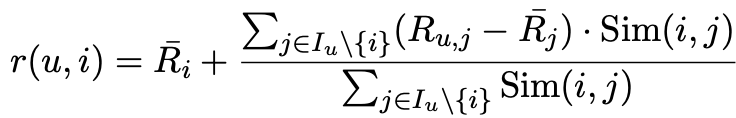

This numerator means when we want to predict what rating the user u would give to the item i, we compute the similarities between item i and the other items the user u purchased before. And weighted them with (the rating given by user u and the average rating the item j received).

When computing similarities,  

1. return the item’s average rating if no similar items exist (i.e., if the denominator is zero),

2. or the global average rating if that item hasn’t been seen before. All averages should be computed on the training set only.

We'll use Jaccard similarity function and compute the MSE on the test dataset at the end.

In [14]:
# Compute the average rating of each item
itemAverages = {}
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

# Compute the global average rating
ratingMean = sum([d['star_rating'] for d in dataTrain]) / len(dataTrain)

In [15]:
# Define rating prediction model based on similarity function (as the picture above)
# predict what rating the user would give to the item
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['product_id']
        if i2 == item: continue # skip the same item
        ratings.append(d['star_rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # If the user hasn't rated any similar items, return the average rating of the item
        if item in itemAverages:
            return itemAverages[item]
        # If the item is totally new (no one rate it before), return the global average rating
        return ratingMean

In [16]:
# Get the predicted rating of the (user, item) pairs in the test dataset and the labels
simPredictions = [predictRating(d['customer_id'], d['product_id']) for d in dataTest]
labels = [d['star_rating'] for d in dataTest]

In [17]:
# Compute the MSE of the result
def MSE(y, ypred):
    diffs = [(a-b)**2 for (a,b) in zip(y,ypred)]
    return sum(diffs) / len(diffs)

MSE(simPredictions, labels)

1.7165667985794817

### 3. Improve the model

We’ll explore a simple form of temporal recommendation known as time-weight collaborative filtering. Here, interactions are weighted in terms of their recency, i.e.,
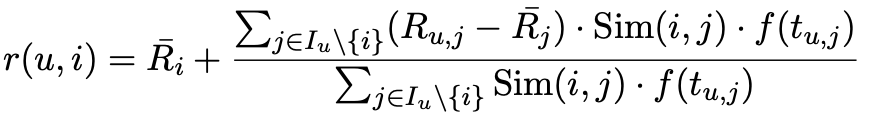

where t_u,j is the timestamp associated with the rating R_u,j.

For example a decay function might be based
on exponential decay, i.e., f(t) = e^-λt, where λ is a controllable parameter.

Here we'll use a simple function of the form f(e^(- |t_u,i − '1970-01-01'| )).

In [18]:
# There is 'review_date' in the data
dataset[0]

{'marketplace': 'US',
 'customer_id': '14640079',
 'review_id': 'RZSL0BALIYUNU',
 'product_id': 'B003LRN53I',
 'product_parent': '986692292',
 'product_title': 'Sennheiser HD203 Closed-Back DJ Headphones',
 'product_category': 'Musical Instruments',
 'star_rating': 5,
 'helpful_votes': '0',
 'total_votes': '0',
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'Five Stars',
 'review_body': 'Nice headphones at a reasonable price.',
 'review_date': '2015-08-31'}

In [28]:
from datetime import datetime

# Get the | t_u,i − 1970-01-01 |
def abs_day_diff(s1):
  d1 = datetime.strptime(s1, '%Y-%m-%d')
  d2 = datetime.strptime('1970-01-01', '%Y-%m-%d')
  diff = abs((d1 - d2).days)

  return diff

In [20]:
# We need reviewsPerItem for extract the review_date
reviewsPerItem = defaultdict(list)

for d in dataTrain:
    user,item = d['customer_id'], d['product_id']
    reviewsPerItem[item].append(d)

In [54]:
# Compute the rating prediction with timestamp
import math
def predictRating_with_timestamp(user,item):

    # return the global average rating if that item hasn’t been seen before.
    if item not in itemAverages:
      return ratingMean

    ratings = []
    similarities = []
    timestamps = []
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue
        ratings.append(d['star_rating'] - itemAverages[j])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[j]))
        # Add timestamps with lambda = 1
        timestamps.append(math.exp(-abs_day_diff(d['review_date'])))

    # mutiple the similarity by timestamp
    similarities_with_time = [(x*y) for x,y in zip(similarities, timestamps)]

    if (sum(similarities_with_time) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        # return itemAverages[item] + sum(weightedRatings) / sum(similarities)
        weightedRatings_with_time = [(x*y) for x,y in zip(weightedRatings, timestamps)]
        return itemAverages[item] + sum(weightedRatings_with_time) / sum(similarities_with_time)
    else:
        # If the user hasn't rated any similar items, return the average rating of the item
        return itemAverages[item]

In [55]:
simPredictions = [predictRating_with_timestamp(d['customer_id'], d['product_id']) for d in dataTest]
labels = [d['star_rating'] for d in dataTest]

In [56]:
# Compute the MSE
MSE_timestamp = MSE(simPredictions, labels)
MSE_timestamp

1.6993690952222666

The MSE decreace a little bit after using timestamp